In [187]:
# import packages
import pandas as pd
import numpy as np
from numpy import array
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from scalecast.Forecaster import Forecaster
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.metrics import mean_squared_error
from math import sqrt

In [188]:
# load the datasets
%store -r sensor_data
%store -r data_hum
%store -r data_pm10
%store -r data_pm2_5
%store -r data_temp

In [189]:
data_pm2_5.head()

,index,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value,day,hour,time,quality
0,1,71,pms5003,riruta,-1.297,36.743,2021-11-01 00:00:16.023904,PM2.5,13.6,Monday,0,Late Night,moderate
1,4,158,pms5003,kinoo,-1.255,36.693,2021-11-01 00:00:16.320020,PM2.5,87.2,Monday,0,Late Night,unhealthy
2,9,93,pms5003,haile_sellasie,-1.292,36.821,2021-11-01 00:00:21.263951,PM2.5,9.6,Monday,0,Late Night,good
3,16,844,pms5003,roysambu,-1.218,36.887,2021-11-01 00:00:24.731908,PM2.5,14.0,Monday,0,Late Night,moderate
4,21,174,pms5003,muthangari,-1.261,36.782,2021-11-01 00:00:26.807988,PM2.5,11.25,Monday,0,Late Night,good


In [190]:
# filter to work with riruta data
riruta = data_pm2_5.loc[data_pm2_5['location'] == 'riruta']
#drop irrelevant columns
riruta_data = riruta.drop(['sensor_type', 'sensor_id', 'location', 'lat', 'lon', 'value_type', 'day', 'time', 'hour', 'quality'], axis = 1)
# cut shape
riruta_data = riruta_data.iloc[:50000]

In [191]:
# set datetime as index
riruta_data.timestamp = pd.to_datetime(riruta_data['timestamp'])
riruta_data = riruta_data.set_index(pd.DatetimeIndex(riruta_data['timestamp']))
# drop extra columns
riruta_data = riruta_data.drop(['index', 'timestamp'], axis=1)

In [192]:
# resample and set freq
riruta_data = riruta_data.resample('10T').nearest()
riruta_data = riruta_data.asfreq('10T')
riruta_data.index.freq = '10T'
riruta_data.index=riruta_data.index.dropna()
print('index null', riruta_data.index.isna().sum())
print('values null', riruta_data['value'].isnull().sum())

index null 0
values null 0


In [193]:
# confirm frequency
print('frequency ',pd.infer_freq(riruta_data.index))

frequency  10T


In [194]:
#check data info
riruta_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13501 entries, 2021-11-01 00:00:00 to 2022-02-02 18:00:00
Freq: 10T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   value   13501 non-null  object
dtypes: object(1)
memory usage: 211.0+ KB


In [195]:
riruta_data.head(15)

,value
timestamp,
2021-11-01 00:00:00,13.6
2021-11-01 00:10:00,19.0
2021-11-01 00:20:00,12.5
2021-11-01 00:30:00,13.0
2021-11-01 00:40:00,19.0
2021-11-01 00:50:00,20.0
2021-11-01 01:00:00,17.0
2021-11-01 01:10:00,18.0
2021-11-01 01:20:00,17.2


In [103]:
riruta_data.tail()

,value
timestamp,
2022-02-02 17:20:00,36.2
2022-02-02 17:30:00,30.0
2022-02-02 17:40:00,18.8
2022-02-02 17:50:00,24.6
2022-02-02 18:00:00,45.0


In [211]:
# check for stationarity
split = int(len(riruta_data) / 2)
X1, X2 = riruta_data['value'][0:split], riruta_data['value'][split:]
X2 = pd.to_numeric(X2, errors='coerce')
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean 1 =', mean1)
print('mean 2 =', mean2)
print('var 1 =', var1)
print('var 2 =', var2)

mean 1 = 24.455274074074072
mean 2 = 22.1251429417864
var 1 = 190.81018904177844
var 2 = 218.39762255363888


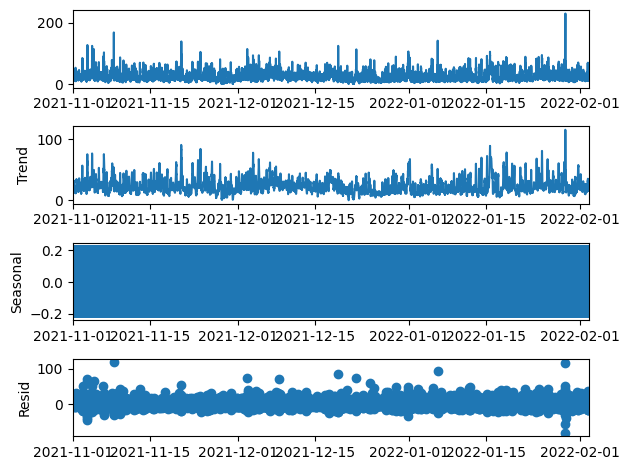

In [13]:
# additional stationarity, cyclic check
%matplotlib inline
decomposition = sm.tsa.seasonal_decompose(riruta_data, model='additive', period = 7)
fig = decomposition.plot()
plt.show()

In [196]:
# split into test and train
train = riruta_data.iloc[:round(len(riruta_data)*0.7)]
test = riruta_data.iloc[round(len(riruta_data)*0.7):]
print(train.shape)
print(test.shape)

(9451, 1)
(4050, 1)


In [197]:
# perform min max scaler
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.fit_transform(test)

In [198]:
# transform univariate time series to supervised learning problem
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X,y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix= i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x,seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)        
    return array(X), array(y)

# transform training data to a supervised learning problem
X, y = split_sequence(scaled_train, 500)
print(X.shape, y.shape)

# transform testing data to a supervised learning problem
x_test, y_test = split_sequence(scaled_test, 500)
print(x_test.shape, y_test.shape)


(8951, 500, 1) (8951, 1)
(3550, 500, 1) (3550, 1)


In [199]:
# transform input from [samples, features] to [samples, timesteps, features]
y = y.reshape((y.shape[0], y.shape[1], 1))

y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
print(y.shape, y_test.shape)

(8951, 1, 1) (3550, 1, 1)


In [200]:
# define model
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(500,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [201]:
# create one test dataset
dataset_test = timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=500,
    # sampling_rate=,
    # batch_size=,
)

In [202]:
# save model
path_checkpoint = "lstm_model.h5"

# define early stopping callback
es_callback = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# fit model
history = model.fit(X, 
                    y, 
                    epochs=10,
    validation_data=[x_test,y_test],
    callbacks=[es_callback, modelckpt_callback]
)

Epoch 1/10
280/280 [==============================] - ETA: 0s - loss: 0.0044
Epoch 1: val_loss improved from inf to 0.00226, saving model to lstm_model.h5
280/280 [==============================] - 73s 244ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 2/10
280/280 [==============================] - ETA: 0s - loss: 0.0026
Epoch 2: val_loss improved from 0.00226 to 0.00193, saving model to lstm_model.h5
280/280 [==============================] - 65s 234ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 3/10
280/280 [==============================] - ETA: 0s - loss: 0.0025
Epoch 3: val_loss improved from 0.00193 to 0.00184, saving model to lstm_model.h5
280/280 [==============================] - 71s 254ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 4/10
280/280 [==============================] - ETA: 0s - loss: 0.0024
Epoch 4: val_loss improved from 0.00184 to 0.00178, saving model to lstm_model.h5
280/280 [==============================] - 69s 245ms/step - loss: 0.0024 - val_loss: 0.0018


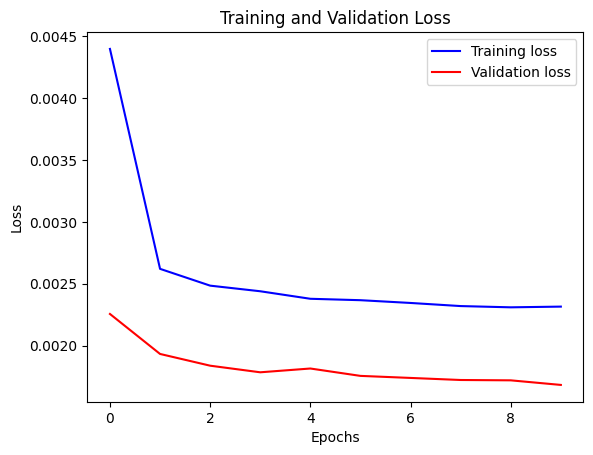

In [203]:
# visualize loss
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [204]:
# predict the test set
test_predictions = model.predict(x_test)
test_predictions

111/111 [==============================] - 8s 67ms/step


array([[0.04046806],
       [0.04908637],
       [0.04740526],
       ...,
       [0.13289532],
       [0.10514444],
       [0.10374002]], dtype=float32)

In [205]:
# confirm length of predictions
print(len(test_predictions))

# invert the min max scaler to get the true predictions
# obj = scaler.fit(test_predictions)
true_predictions = scaler.inverse_transform(test_predictions)

3550


In [206]:
# create one dataframe with the true and predicted values
predicted = pd.DataFrame(true_predictions)
test_plot = test.iloc[500:]
predicted = predicted.set_index(test_plot.index)
full_test = test_plot
full_test['predictions']=predicted
full_test

C:\Users\a\AppData\Local\Temp\ipykernel_22300\1872209753.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_test['predictions']=predicted


,value,predictions
timestamp,,
2022-01-09 02:30:00,14.25,11.267186
2022-01-09 02:40:00,11.6,13.240777
2022-01-09 02:50:00,15.2,12.855804
2022-01-09 03:00:00,16.6,14.473936
2022-01-09 03:10:00,19.2,15.914989
...,...,...
2022-02-02 17:20:00,36.2,32.456516
2022-02-02 17:30:00,30.0,34.623154
2022-02-02 17:40:00,18.8,32.433029


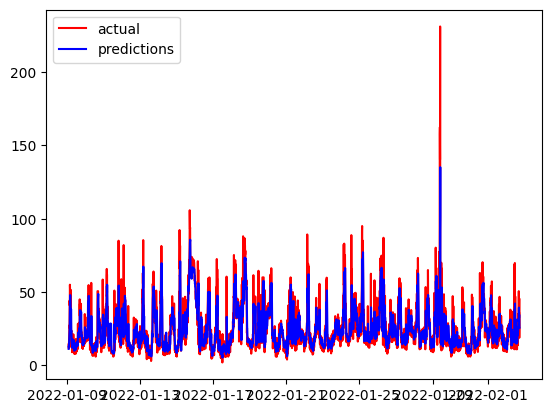

In [207]:
# visualize prediction
plt.plot(full_test['value'], color = 'red', label = 'actual')
plt.plot(full_test['predictions'], color = 'blue', label = 'predictions')
plt.legend()
plt.show()

In [210]:
# evaluate model
MSE = np.square(np.subtract(full_test['value'],full_test['predictions'])).mean() 
 
RMSE = sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

9.394218429479025
